In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsa
import ruptures as rpt
sys.path.append('../..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
import traceback
from itertools import product

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
SWITCH_COLOR = '#B07A3B'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
#PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']#V1
PHASE_COLORS = ['#E2CAE3','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']#V2

#dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']
dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108','DS_15','DS_19']

#act_directory = 'D:\\Analysis_Cache_archived_Oct_27_2022'
act_directory = 'C:\\Users\insan\\Desktop\\Analysis_Cache_Aug23'

#act_directory = 'D:\\Analysis_Cache'
ops_directory = 'D:\\Opsin_Cache'
beh_directory = 'P:\\Behavioor'

stdfont = 14
stdyfrac = 0.06

In [2]:
pre_hM4D = [1.735,1.02,1.193866667,1.603,1.89325,1.3695,1.811,1.621,1.77]
pre_mCherry = [1.685,1.53,1.786,1.711]
pre_Saline = [2,1.5,1.82]

In [3]:
post_hM4D = [-0.57,0.244,0.0535,0.955,0.6412,0.26,0.743,-0.01,0.336]
post_mCherry = [1.46,1.74,1.55,0.904,1.8404]
post_Saline = [1.57,1.64,1.72,1.5,1.12]

C:\Users\insan\anaconda3\envs\EphysPlotting\lib\site-packages\outdated\utils.py:14: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.5.2, the latest is 0.5.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  return warn(


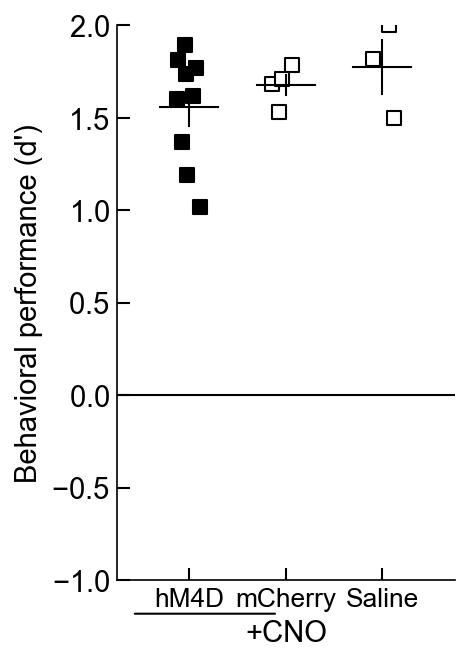

In [8]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(2.25,3.7, left=.3, bottom=.3, right=0, top=0)
#switch_offset = 0.25
switch_offset = 0
################################################################################################################

#Plot figure

data = [pre_hM4D,pre_mCherry,pre_Saline]
labels = ['hM4D','mCherry','Saline']
numCon = len(data)

sz = 35
width = 0.3

for idx,column in enumerate(data):
    Y = ilep.rmnan(column)
    X = np.random.uniform(-width/2,width/2,size=len(Y)) + idx
    
    
    mean = np.mean(Y)
    SEM = sem(Y)
    if idx == 0:
        ax.scatter(X-switch_offset,Y,s=40,color='black',marker='s')
    else:
        ax.scatter(X-switch_offset,Y,s=40,color='white',edgecolor='black',marker='s')
        
    ax.plot([idx-switch_offset-width,idx-switch_offset+width],[mean]*2,color='k',lw=1, clip_on = False)
    ax.plot([idx-switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1, clip_on = False)
        
################################################################################################################

labels = ['hM4D','mCherry','Saline']

ax.set_ylim([-1,2])
ylab = ax.set_ylabel('Behavioral performance (d\')')

ax.set_xlim([-0.75-switch_offset,2.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset])
ax.set_xticklabels(labels)
xlab = ax.set_xlabel('')

xtick_pos_pre = ax.get_xticks()[1]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, '+CNO', ha='center', va='bottom', fontsize=stdfont,color='k')
ax.annotate('', xy=(0.04, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)
ax.axhline(0,color='black',lw=1)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass


artists = [ylab,t1]
#fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\pre_DREADDS.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

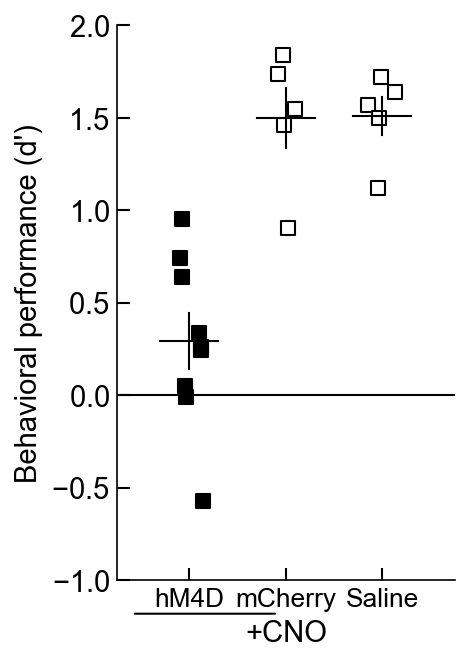

In [9]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

fig,ax = make_axis_size(2.25, 3.7, left=.3, bottom=.3, right=0, top=0)
#switch_offset = 0.25
switch_offset = 0
################################################################################################################

#Plot figure

data = [post_hM4D,post_mCherry,post_Saline]
labels = ['hM4D','mCherry','Saline']
numCon = len(data)

sz = 35
width = 0.3

for idx,column in enumerate(data):
    Y = ilep.rmnan(column)
    X = np.random.uniform(-width/2,width/2,size=len(Y)) + idx
    
    
    mean = np.mean(Y)
    SEM = sem(Y)
    if idx == 0:
        ax.scatter(X-switch_offset,Y,s=40,color='black',marker='s')
    else:
        ax.scatter(X-switch_offset,Y,s=40,color='white',edgecolor='black',marker='s')
        
    ax.plot([idx-switch_offset-width,idx-switch_offset+width],[mean]*2,color='k',lw=1, clip_on = False)
    ax.plot([idx-switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1, clip_on = False)
        

    
    
################################################################################################################

labels = ['hM4D','mCherry','Saline']

ax.set_ylim([-1,2])
ylab = ax.set_ylabel('Behavioral performance (d\')')

ax.set_xlim([-0.75-switch_offset,2.75+switch_offset])
ax.set_xticks([0-switch_offset,1-switch_offset,2-switch_offset])
ax.set_xticklabels(labels)
xlab = ax.set_xlabel('')

xtick_pos_pre = ax.get_xticks()[1]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)
t1 = ax.text(xtick_pos_pre, Yval, '+CNO', ha='center', va='bottom', fontsize=stdfont,color='k')
ax.annotate('', xy=(0.04, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)
ax.axhline(0,color='black',lw=1)
for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass


artists = [ylab,t1]
#fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\post_DREADDS.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

## Lick rate

In [4]:
CNO = [380.2,376.6,328,296]
Saline = [316.2,407.8,443.34,400.4]

In [5]:
ttest_ind(CNO,Saline)

Ttest_indResult(statistic=-1.3867556341964165, pvalue=0.21484181627025195)

meta NOT subset; don't know how to subset; dropped


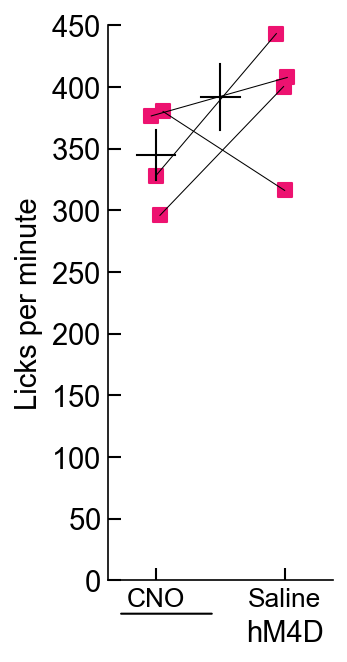

In [14]:
fig,ax = make_axis_size(1.5, 3.7, left=.3, bottom=.3, right=0, top=0)
#switch_offset = 0.25
switch_offset = 0
################################################################################################################

#Plot figure

data = [CNO,Saline]
labels = ['CNO','Saline']
numCon = len(data)

sz = 35
width = 0.3

X_position_arr = []
for idx,column in enumerate(data):
    Y = ilep.rmnan(column)
    mean = np.mean(Y)
    SEM = sem(Y)
    
    if idx==0:
        X = np.random.uniform(-width/2,width/2,size=len(Y)) + idx
    else:
        X = np.random.uniform(-width/2,width/2,size=len(Y)) + idx+1
    
    

    
    X_position = X
    X_position_arr.append(X_position)
    
    ax.scatter(X_position,Y,s=40,color='#ED1270',marker='s',clip_on = False)
    
        
    ax.plot([idx-switch_offset-width,idx-switch_offset+width],[mean]*2,color='k',lw=1, clip_on = False)
    ax.plot([idx-switch_offset]*2,[mean-SEM,mean+SEM],color='k',lw=1, clip_on = False)
    

arr1 = X_position_arr[0]
arr2 = X_position_arr[1]
for i in range(len(arr1)):
    ax.plot([arr1[i],arr2[i]],[CNO[i],Saline[i]],'black',lw=0.5,clip_on = False)
################################################################################################################

labels = ['CNO','Saline']

ax.set_ylim([0,450])
#ax.set_xticks([0,150,250,350,450])
#ax.set_xticklabels(['0','150','250','350','450'])
ylab = ax.set_ylabel('Licks per minute')

ax.set_xlim([-0.75-switch_offset,2.75+switch_offset])
ax.set_xticks([0-switch_offset,2-switch_offset])
ax.set_xticklabels(labels)
xlab = ax.set_xlabel('')

xtick_pos_pre = ax.get_xticks()[1]
Yval = ilep.getPrePostLabelYval(ax.get_ylim(),Yfrac=-2*stdyfrac)

t1 = ax.text(xtick_pos_pre, Yval, 'hM4D', ha='center', va='bottom', fontsize=stdfont,color='k')
ax.annotate('', xy=(0.04, -stdyfrac), xycoords='axes fraction', xytext=(0.48, -stdyfrac),arrowprops=dict(arrowstyle='-', color='black'))

ax.tick_params(direction='in', length=6, width=1)

for item in ([ax.title, ax.xaxis.label, ax.yaxis.label] +
    ax.get_xticklabels() + ax.get_yticklabels()):
    item.set_fontsize(stdfont)
for item in (ax.get_xticklabels()):
    item.set_fontsize(stdfont*0.9)
    pass


artists = [ylab,t1]
fig.savefig(os.path.join('C:\\Users\insan\\Desktop\\lick rate.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')